In [1]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import *
from sklearn.kernel_approximation import Nystroem
import matplotlib.pyplot as plt 
import numpy as np

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
"""
Neural Tangent Kernel Precompute
https://github.com/LeoYu/neural-tangent-kernel-UCI/
"""
def ntk_value(X, d_max, fix_dep): 
    K = np.zeros((d_max, X.shape[0], X.shape[0]))
    S = np.matmul(X, X.T)
    H = np.zeros_like(S)
    for dep in range(d_max):
        if fix_dep <= dep:
            H += S
        K[dep] = H
        L = np.diag(S)
        P = np.clip(np.sqrt(np.outer(L, L)), a_min = 1e-9, a_max = None)
        Sn = np.clip(S / P, a_min = -1, a_max = 1)
        S = (Sn * (math.pi - np.arccos(Sn)) + np.sqrt(1.0 - Sn * Sn)) * P / 2.0 / math.pi
        H = H * (math.pi - np.arccos(Sn)) / 2.0 / math.pi
    return K[d_max - 1]

## Gaussian Process Practice

In [3]:
# Dataset
rng = np.random.RandomState(624562)
X = np.linspace(0, 10, 1000)
y = X * np.sin(X)

X = X.reshape((-1, 1))
y = y.reshape((-1, 1))

training_indices = rng.choice(np.arange(y.size), size=10, replace=False)
x_train, y_train = X[training_indices], y[training_indices]
y_train_noisy = y_train + rng.normal(loc=0.0, scale=0.75, size=y_train.shape)

In [4]:
X.shape, y.shape

((1000, 1), (1000, 1))

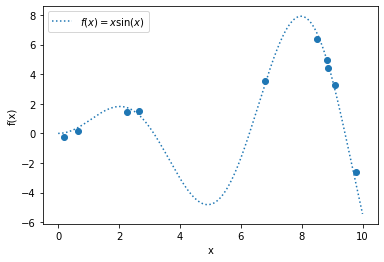

In [5]:
fig, ax = plt.subplots()
ax.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle='dotted')
ax.scatter(x_train, y_train_noisy)
ax.legend()
ax.set_xlabel("x")
_=ax.set_ylabel("f(x)")
plt.show()

In [15]:
kernel = 1 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2), nu=0.5)
gp = GPR(kernel=kernel, n_restarts_optimizer=9)
gp.fit(x_train, y_train_noisy)
gp.kernel_

3.15**2 * Matern(length_scale=1.83, nu=0.5)

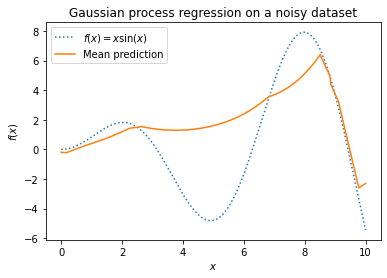

In [16]:
mean_pred, std_pred = gp.predict(X, return_std=True)

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")

plt.plot(X, mean_pred, label="Mean prediction")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on a noisy dataset")

In [8]:
laplace_kernel = Matern(
    length_scale=1.0,
    length_scale_bounds=(1e-5, 1e5),
    nu=1/2
    )

